In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from utils import audio, channels, synchronize, channel_estimate,ofdm, encode, decode, preamble,correction

cwd = os.getcwd()

In [2]:
#baisc parameter definition
filename = 'thinkpad_75_frames_1'            #rememeber to change everytime

chirp_duration = 1
record_duration = 50
fs = 48000

DFT_LENGTH = 4096
CP_LENGTH = 512
OFDM_LENGTH = 4608
symbol_per_frame = 128
low_freq = 1000
high_freq = 10000

encode_method = 'qpsk'
double_chirp = False
known_ofdm = True

#define chirp used in the signal
chirp_range = [1000,10000]
chirp = preamble.generate_chirp(chirp_duration, fs, low=chirp_range[0], high=chirp_range[1], silence_duration=0, double=double_chirp)

#define known ofdm symbol
#seed_known = 7
known_ofdm = True
repeat_time = 4
# if known_ofdm:
#     known_ofdm_data = preamble.generate_known_ofdm(fs,DFT_LENGTH,CP_LENGTH,low_freq,high_freq,encode_method,repeat_time,seed_known)
# else:
#     known_ofdm_data = np.array([])
known_ofdm_data = preamble.load_known_ofdm(CP_LENGTH,repeat_time)
spb = ofdm.subcarriers_per_block(fs,DFT_LENGTH,low_freq,high_freq)

In [ ]:
#record and save
#received_signal = audio.record(record_duration, fs)
#audio.signal_to_wav(received_signal,fs,filename,"audio_files")

In [3]:
#load recorded signals
received_signal,_ = np.array(audio.wav_to_signal(filename,'audio_files'))

<ipython-input-3-0b1a1f45bd19>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  received_signal,_ = np.array(audio.wav_to_signal(filename,'audio_files'))


In [4]:
#synchronize: convolve and find
start,convolved = synchronize.chirp_synchronize(received_signal,chirp_range, fs,duration=1)
event_end = np.array(synchronize.impulse_detect(abs(convolved),fs,duration = 1,window_time=0.3,threshold=2))

In [ ]:
#plot the convolved result
plt.plot(convolved)
for pos in event_end:
    plt.axvline(x = pos, color = 'r')
plt.show()

In [ ]:
# #check that the synchronization is correct
# a1 = np.argmax(abs(convolved[:record_duration*fs//2]))
# a2 = np.argmax(abs(convolved[record_duration*fs//2:])) + record_duration*fs//2

# print(event_end,"max of convoled data: ", a1,a2)

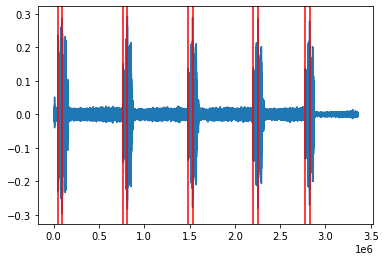

10 chirp events found at [  45702   93696  765319  813313 1484937 1532937 2204554 2252548 2776715
 2824709] , is that as expected? 


In [5]:
#plot found chirp in received signal
event_start = event_end - fs*chirp_duration
chirp_received = received_signal[event_start[0]:event_start[0]+chirp_duration*fs]   #taking only the first event for the time being

plt.plot(received_signal)
for pos in event_start:
    plt.axvline(x = pos, color = 'r')
plt.show()
#event = event_start
print(str(len(event_start))+" chirp events found at "+ str(event_start)+" , is that as expected? ")

In [6]:
events = np.array([ [event_start[2*i+1],event_start[2*i+2]] for i in range(len(event_start)//2-1) ])
chirp_start = events[:,0]
chirp_end = events[:,1]
interval = chirp_end - chirp_start
ofdm_num = np.array([round((interval[j]-chirp_duration*fs-2*known_ofdm_data.size)/OFDM_LENGTH) for j in range(events.shape[0])])
print(ofdm_num)
ori_length = ofdm_num * (DFT_LENGTH+CP_LENGTH) + 2*known_ofdm_data.size + chirp_duration*fs
sample_diffs = chirp_end - chirp_start - ori_length
frame_count = sample_diffs.size
print(str(frame_count)+" frames found, sample diff ",sample_diffs)

[128 128 128  96]
4 frames found, sample diff  [7 8 1 7]


In [7]:
#estimate with known ofdm
known_ofdm_start = (events[:,0] + fs*(chirp_duration)).astype(int) #need to change accordingly
known_ofdm_end = known_ofdm_start + known_ofdm_data.size

received_known = np.array([received_signal[known_ofdm_start[i]:known_ofdm_end[i]] for i in range(frame_count)]) #received ofdm part

#remove the first cyclic prefix manually then find discarded
received_known = received_known[:,CP_LENGTH:]

#estimate
# for i in range(frame_count):
#     H_known_ofdm = ofdm.known_ofdm_estimate_edited(received_known[i,:],known_ofdm_data[CP_LENGTH:CP_LENGTH+DFT_LENGTH],DFT_LENGTH,CP_LENGTH,low_freq,high_freq,fs)

H_known_ofdm = np.array([ofdm.known_ofdm_estimate_edited(received_known[i,:],known_ofdm_data[CP_LENGTH:CP_LENGTH+DFT_LENGTH],DFT_LENGTH,CP_LENGTH,low_freq,high_freq,fs) for i in range(frame_count)])




In [ ]:
#used for ofdm after a chirp only
ofdm_start = known_ofdm_end
ofdm_end = ofdm_start+ofdm_num*(DFT_LENGTH+CP_LENGTH)
#received_ofdm = np.array([received_signal[ofdm_start[i]:ofdm_end[i]] for i in range(frame_count)])  #received ofdm information
#print(received_ofdm.size)
deconvolved_list = []
for i in range(frame_count):
    received_ofdm = received_signal[ofdm_start[i]:ofdm_end[i]]
    
    #process received data
    fft = ofdm.ofdm_to_fourier(received_ofdm, DFT_LENGTH, CP_LENGTH)
    discarded = ofdm.subcarrier_extract(fft, DFT_LENGTH, fs, low_freq, high_freq)
    deconvolved = ofdm.deconvolve(discarded, H_known_ofdm[i], DFT_LENGTH, fs, low_freq, high_freq,True)
    deconvolved_list += [deconvolved]


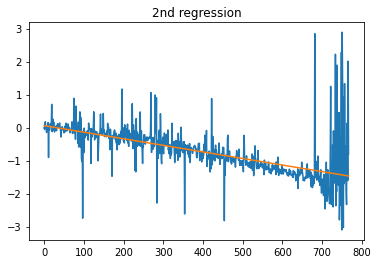

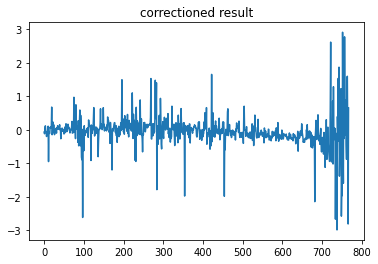

-0.008861746076984943 -0.8886578132608022
[array([ 0.47293544-0.30325588j, -0.37923828-0.69030451j,
        0.4364963 -0.571824j  , ...,  0.42133873-0.03083954j,
        0.13041226-0.4197713j , -0.12190292+0.12497443j]), array([ 0.4557946 -0.37943963j,  0.56833652-0.12018122j,
        0.46364075-0.02394264j, ..., -0.17197534+0.08314483j,
       -0.43242415-0.3548947j ,  0.11109057+0.10360101j]), array([0.69933486+0.324189j  , 0.36413616-0.88246363j,
       0.51217163-0.64190951j, ..., 0.34482385+0.1379843j ,
       0.22408885-0.16412152j, 0.2022485 +0.13717776j]), array([ 0.34740589+0.43557042j, -0.05302931+0.04202926j,
       -0.21647813+0.15859743j, ..., -0.1544852 +0.01663571j,
        0.10408803+0.39986217j,  0.15651624+0.15009101j])]


In [9]:
# phase correction
from IPython.display import clear_output
#sample_diff = sample_diffs
for i in range(frame_count):
    deconvolved_list[i] = correction.phase_correction(deconvolved_list[i], sample_diffs[i], DFT_LENGTH, CP_LENGTH, fs, low_freq, high_freq,chirp)
    print(deconvolved_list[i].shape)

    #plot the phase difference between the two channel estimation done with known ofdm symbols
    phase_diff,H1,H2 = correction.phase_difference(received_signal, events[i,:],known_ofdm_data,CP_LENGTH,DFT_LENGTH,fs,low_freq,high_freq,repeat_time)
    
    #find regression of the phase diff plot by looking at a selected linear range
    #iterate until satisfied with range for regression
    reply = "n"
    while reply != "y":
        regression_range_1 = np.array(input("range to perform regression: ").split()).astype(int)
        clear_output()
        start1,end1 = regression_range_1
        if end1 > phase_diff.size:
            end1 = phase_diff.size
        plt.plot(phase_diff[start1:end1])
        section1 = phase_diff[start1:end1]
        x_1 = np.linspace(0,end1,num=(end1-start1))
        slope1, intercept1, r_value, p_value, std_err = scipy.stats.linregress(x_1, section1)
        plt.plot(x_1*slope1+intercept1)
        print(slope1,intercept1)
        plt.title("1st regression")
        plt.show()
        reply = input("confirm range? y/n")

    clear_output()
    
    deconvolved_list[i] = correction.regression_correction(spb,slope1,intercept1,H1,H2,deconvolved_list[i],symbol_per_frame)

In [10]:
#check accuracy
new = True
if new:
    np.random.seed(8)
    encoded = np.random.randint(2, size=int(2*128*spb*3.75))
    np.savetxt('encoded', encoded, fmt='%i')


In [ ]:
phase_plot_range = 3000
plt.scatter(np.real(deconvolved[:phase_plot_range]),np.imag(deconvolved[:phase_plot_range])) #plot the received phase distribution
print(deconvolved.size)

In [11]:
decoded = np.array([],dtype='int')
for i in range(frame_count):
    result = decode.qpsk_decode(deconvolved_list[i])
    decoded = np.append(decoded,result)

print(encoded.size, decoded.size)
print("source:\n", encoded[:30])
print("decoded:\n", decoded[:30])

737280 737280
source:
 [1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1]
decoded:
 [1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1]


In [12]:
equality = encoded == decoded[:encoded.size]
equality = equality[:]
print("correct rate:\n", np.sum(equality.astype(int))/equality.size)

correct rate:
 0.8892876519097223


In [ ]:
#for multiframes
if new:
    np.random.seed(8)
    encoded_3 = np.random.randint(2, size=int(2*128*spb*3.75))
    np.savetxt('encoded', encoded_3, fmt='%i')

encoded_3 = np.reshape(encoded_3,(-1,2*spb*128))
encoded = encoded_3[2,:]

decoded = decode.qpsk_decode(deconvolved)
equality = encoded == decoded[:encoded.size]
#equality = equality[:]
print("correct rate:\n", np.sum(equality.astype(int))/equality.size)

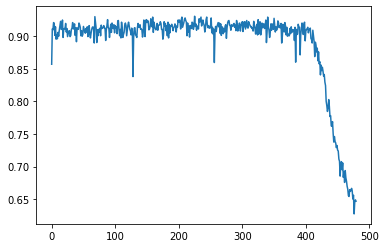

In [13]:
#error of each symbol
e_symbol = [0]*int(symbol_per_frame*3.75)
for n in range(int(symbol_per_frame*3.75)):
    n=int(n)
    a = equality[2*spb*n:2*spb*(n+1)]
    e_symbol[n] = np.round(np.sum(a.astype(int))/a.size,4)
plt.plot(e_symbol)